<div class="alert alert-info">
<u><strong>Authors:</strong></u> <b>Alberto Vavassori</b> (alberto.vavassori@polimi.it), <b>Emanuele Capizzi</b> (emanuele.capizzi@polimi.it) - DICA - Politecnico di Milano - GIS GEOLab <br>
Developed within the LCZ-ODC project, funded by the Italian Space Agency (agreement n. 2022-30-HH.0).
</div>

# Sentinel-2 imagery preprocessing and preparation
<a id='TOC_TOP'></a>
This notebook allows to preprocess the Sentinel-2 imagery in order to be ready for next stages of processing. In particulare it allows to perform the following steps indicated in these sections: <br>
 1. [convert the Sentinel-2 bands from .jp2 to GeoTIFF and stack the bands into a single multiband GeoTIFF file](#sec1)  
 2. [merge Sentinel-2 tiles (band by band) into a unique GeoTIFF file](#sec2)
 3. [clip the Sentinel-2 merged image over the PRISMA image extent](#sec3)   
 4. [repeat the same procedure for bands from B02 to B12 (for spectral signature plotting)](#sec4)
<hr>

<div class="alert alert-block alert-warning"> <b>NOTE:</b> The notebook allows you to merge tiles <b>T32TMR</b> and <b>T32TNR</b> of Sentinel-2, which entirely cover the Metropolitan City of Milan (case study of the LCZ-ODC project).
</div>

### Import libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio import mask
from rasterio.warp import reproject, Resampling
import ipywidgets as widgets
import h5py
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from skimage import exposure

# Import functions and set auto-reload
from functions import *
%load_ext autoreload
%autoreload 2

### Select S2 datasets

Select interactively the resolution of Sentinel-2 bands to be used for the preprocessing step:

In [ ]:
w_resol = widgets.RadioButtons(
    options=['R10m', 'R20m', 'R60m'],
    description='S2 resolution:',
    value='R20m',
    disabled=False)
w_resol

In [ ]:
sel_resol = w_resol.value
print(f"The selected resolution is {sel_resol}.")

Select the date for Sentinel-2. The dates are in the **yyyy-mm-dd** format. For example, the 2023-02-10 date will correspond to 10th February 2023.
Dates available:
- 2023-02-10
- 2023-03-22
- 2023-04-26
- 2023-06-25
- 2023-07-10

In [ ]:
date_s2_w = widgets.Dropdown(
    options=['2023-02-10', '2023-03-22', '2023-04-26', '2023-06-25', '2023-07-10', '2023-08-19'],
    value='2023-02-10',
    description='Sentinel-2 date:',
    disabled=False,
    layout={'width': 'max-content'},
    style = {'description_width': 'initial'}
)
date_s2_w

In [ ]:
date_prisma_w = widgets.Dropdown(
    options=['2023-02-09', '2023-03-22', '2023-04-08', '2023-06-17', '2023-07-10', '2023-08-08'],
    value='2023-02-09',
    description='PRISMA date:',
    disabled=False,
    layout={'width': 'max-content'},
    style = {'description_width': 'initial'}
)
date_prisma_w

In [ ]:
sel_s2_date = date_s2_w.value
sel_prisma_date = date_prisma_w.value
print(f"The selected dates are -> Sentinel-2: {sel_s2_date} | PRISMA: {sel_prisma_date}.")

The following function allows you to automatically get the path of each Sentinel-2 band with the corresponding spatial resolution selected by the user. The files are contained inside the **imagery_S2_PRISMA** folder, which contains all the data.

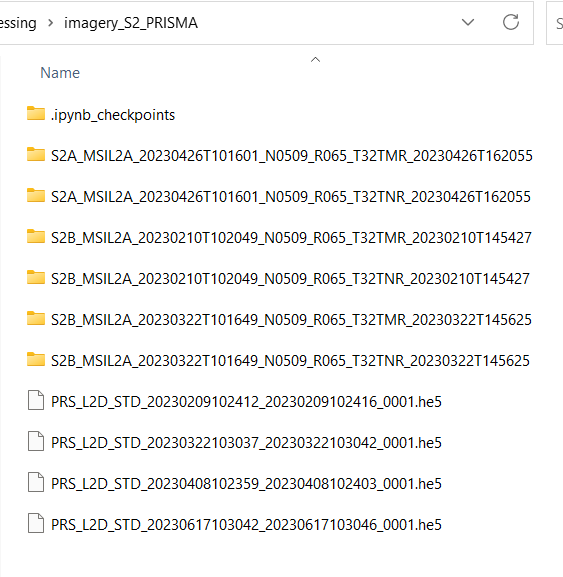

Call the function to automatically retreive the Sentinel-2 tiles path:

In [ ]:
path_TMR, path_TNR = get_TMR_TNR_paths('imagery_S2_PRISMA', sel_resol, sel_s2_date)

Then, define the path to the PRISMA image to be used for clipping the Sentinel-2 image. This image cover the entire study area chosen during the project:

In [ ]:
selected_image_prisma = get_PRISMA_path('imagery_S2_PRISMA', sel_prisma_date)
print(selected_image_prisma)

In [ ]:
f = h5py.File(selected_image_prisma, 'r')

## 1. <a id='sec1'></a>Convert bands format from .jp2 to GeoTIFF and stack bands in a single GeoTIFF

[Back to top](#TOC_TOP)


The following code will convert the bands selected in the band_names list in GeoTIFF format and it stacks the bands in a single GeoTIFF image. <br>
Let's check the files available inside each folder and define the output name of the stacked image. In particular the name will include:
- *tile name*: e.g. T32TMR or T32TNR
- *date of acquisition*: e.g. 20230210T102049
- *spatial resolution*: e.g. 20m

The output name file will be something similar to: `T32TMR_20230210T102049_20m`

In [ ]:
# Create the folder/directory if it doesn't exist where all the output are saved
if not os.path.exists('S2_outputs'):
    os.makedirs('S2_outputs')

# List the files contained inside the folder (tile TMR)
dir_list_TMR = os.listdir(path_TMR)

In [ ]:
dir_list_TMR

In [ ]:
# Define the GeoTIFF image output name (tile TMR)
TMR_output_name = 'S2_outputs/T32TMR_' + sel_s2_date.replace('-', '') + '_' + sel_resol[1:] + '.tif'
TMR_output_name

In [ ]:
# List the files contained inside the folder (tile TNR)
dir_list_TNR = os.listdir(path_TNR)

In [ ]:
# Define the GeoTIFF image output name (tile TNR)
TNR_output_name = 'S2_outputs/T32TNR_' + sel_s2_date.replace('-', '') + '_' + sel_resol[1:] + '.tif'
TNR_output_name

Now it is possible to select the bands that you want to stack in a single image.


<div class="alert alert-block alert-warning"> <b>NOTE:</b> only imagery with the same resolution and that are contained in the same folder can be merged.
</div>

In [ ]:
band_names = [i[23:26] for i in dir_list_TMR]

checkboxes = [widgets.Checkbox(value=False, description=label) for label in band_names]
output = widgets.VBox(children=checkboxes)
display(output)

In [ ]:
dir_list_TMR

In [ ]:
# Create a list with the selected bands
selected_bands = ['B02', 'B03', 'B04', 'B8A']
#selected_bands = []
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        selected_bands = selected_bands + [checkboxes[i].description]
print(selected_bands)

# # Otherwise use a predefined list
# band_names = ['B8A', 'B04', 'B03', 'B02']

The following function allows to convert the band format from .jp2 to GeoTIFF and stack the GeoTIFF bands into a single multiband GeoTIFF image.

Call the function to create the stacked files for each tile:

In [ ]:
convert_jp2_to_geotiff(path_TMR, selected_bands, TMR_output_name)

In [ ]:
convert_jp2_to_geotiff(path_TNR, selected_bands, TNR_output_name)

In [ ]:
# Open the first image using rasterio
with rasterio.open(TMR_output_name) as src:
    img1 = (src.read(indexes = [3,2,1]) - 1000 ) / 10000

    show(img1*3)

In [ ]:
# Open the second image using rasterio
with rasterio.open(TNR_output_name) as src:
    img2 = (src.read(indexes = [3,2,1]) - 1000) / 10000
    
    show(img2*3)

## 2. <a id='sec2'></a>Merge Sentinel-2 tiles

[Back to top](#TOC_TOP)

This part of the code allows to create the mosaicked image by merging the desired Sentinel-2 tiles. <br> In the following list, the desired tiles have to be specified. In this case, the TMR and TNR tiles (generated in the previous step) are being used:

In [ ]:
tiles = [TMR_output_name, TNR_output_name]

Let's automatically define the output name of the mosaic:

In [ ]:
mosaic_name = 'S2_outputs/S2_' + sel_s2_date.replace('-', '') + '_' + sel_resol[1:] + '.tif'
mosaic_name

The following function allows to merge the Sentinel-2 tiles into a single mosaic image and write it in a GeoTIFF file:

In [ ]:
merge_tiles_s2(tiles, mosaic_name)

In [ ]:
# Open the first image using rasterio
with rasterio.open(mosaic_name) as src:
    mos = src.read(indexes = [3,2,1])
    src_meta = src.meta
    
    show(mos*3)

## 3. <a id='sec3'></a>Clipping Sentinel-2 image to PRISMA image extent

[Back to top](#TOC_TOP)

This part is used to clip the Sentinel-2 mosaic over the PRISMA image extent.

<div class="alert alert-block alert-warning"> <b>NOTE:</b> The coordinates corresponding to the PRISMA imagery bounding box are contained inside the PRISMA data cube and can be extracted as shown in the next steps.
</div>

Define the dataframe containing the bounding box of PRISMA image (the bounding box is provided in the attributes of the PRISMA file):

In [ ]:
df = pd.DataFrame({'east': [f.attrs['Product_ULcorner_easting'],
                            f.attrs['Product_URcorner_easting'],
                            f.attrs['Product_LRcorner_easting'],
                            f.attrs['Product_LLcorner_easting']],
                   'north': [f.attrs['Product_ULcorner_northing'],
                             f.attrs['Product_URcorner_northing'],
                             f.attrs['Product_LRcorner_northing'],
                             f.attrs['Product_LLcorner_northing']]})

Create a polygon shape using the bounding box coordinates stored in the dataframe:

In [ ]:
polygon_geom = Polygon(zip(df.east, df.north))
polygon = gpd.GeoDataFrame(index = [0], crs='epsg:32632', geometry = [polygon_geom])
polygon = polygon.buffer(15, join_style=2)
shapes = polygon.geometry

Save the polygon of the study area. It corresponds to the image of the 9th February 2023:

In [ ]:
#polygon.to_file('study_area.gpkg')  #study area is the one from image of 9th February 2023

Use the `rasterio.mask` function to clip the Sentinel-2 image with the previously created polygon (bounding box):

In [ ]:
with rasterio.open(mosaic_name) as src:
    prova_meta = src.meta.copy()
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True, all_touched=True)
    out_meta = prova_meta
    
# Save clipped imagery - Update metadata
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

Automatically define the output image name:

In [ ]:
mosaic_name_clip = mosaic_name[0:-4] +'_clip.tif'
mosaic_name_clip

Save the clipped mosaic image:

In [ ]:
with rasterio.open(mosaic_name_clip, "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
# Open the first image using rasterio
with rasterio.open(mosaic_name_clip) as src:
    img1 = src.read(indexes = [3,2,1])
    
    # Calculate the 2nd and 98th percentiles of the image
    p2, p98 = np.percentile(img1, (2, 98))

    # Apply a contrast stretch to the image
    img1 = exposure.rescale_intensity(img1, in_range=(p2, p98))

    # Create a figure with two axes
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    show(img1)

## 4. <a id='sec4'></a>Repeat the same procedure for bands from B02 to B12 (_for spectral signature plotting_)

[Back to top](#TOC_TOP)

In [ ]:
selected_bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12']

In [ ]:
convert_jp2_to_geotiff(path_TMR, selected_bands, TMR_output_name)

In [ ]:
convert_jp2_to_geotiff(path_TNR, selected_bands, TNR_output_name)

In [ ]:
tiles = [TMR_output_name, TNR_output_name]

In [ ]:
mosaic_name = 'S2_outputs/S2_' + sel_s2_date.replace('-', '') + '_' + sel_resol[1:] + '_all_bands.tif'
mosaic_name

In [ ]:
merge_tiles_s2(tiles, mosaic_name)

In [ ]:
with rasterio.open(mosaic_name) as src:
    prova_meta = src.meta.copy()
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True, all_touched=True)
    #out_image = (out_image - 1000) / 10000
    out_meta = prova_meta
    
# Save clipped imagery - Update metadata
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

In [ ]:
ninth_element = out_image[8, :, :]
out_image = np.delete(out_image, 8, axis = 0)
out_image = np.insert(out_image, 6, ninth_element, axis = 0)

In [ ]:
mosaic_name_clip = mosaic_name[0:-4] +'_clip.tif'
mosaic_name_clip

In [ ]:
with rasterio.open(mosaic_name_clip, "w", **out_meta) as dest:
    dest.write(out_image)

### Resampling all S2 bands from 20m to 30m

In [ ]:
with rasterio.open(mosaic_name_clip) as src:
    # Read the data from the red, green, and blue bands
    data = src.read()
    src_meta = src.meta

dst_resolution = 30

dst_meta = src_meta.copy()
dst_meta.update({
    'height': int(src.height * src.transform[0] / dst_resolution),
    'width': int(src.width * src.transform[0] / dst_resolution),
    'transform': rasterio.Affine(dst_resolution, 0, src.bounds.left, 0, -dst_resolution, src.bounds.top),
    'dtype' : 'float32'
})

resampled_data = np.zeros((src.count, dst_meta['height'], dst_meta['width']), dtype=data.dtype)
reproject(data,resampled_data,src_transform=src.transform,src_crs=src.crs, dst_transform=dst_meta['transform'], dst_crs=src.crs, resampling=Resampling.bilinear);

s2_30_path = 'S2_outputs/S2_'+ sel_s2_date.replace('-', '') + '_30m_all_bands_clip.tif'
print(f"Sentinel-2 image with {dst_resolution}m resolution path --> {s2_30_path}")

with rasterio.open(s2_30_path, 'w', **dst_meta) as dst:
    dst.write(resampled_data)

In [ ]:
if os.path.isfile(mosaic_name):
    os.remove(mosaic_name)
    
if os.path.isfile(TNR_output_name):
    os.remove(TNR_output_name)
    
if os.path.isfile(TMR_output_name):
    os.remove(TMR_output_name)